In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import logging

from mpl_bsic import apply_bsic_logo, apply_bsic_style, check_figsize
from mpl_bsic.apply_bsic_style import DEFAULT_TITLE_STYLE

from backtester.strategy_paper import PaperStrategy
from utils.load_data import load_data

In [4]:
log = logging.getLogger("backtester")
log.setLevel(20)

In [5]:
fx_fixes, swaps_fixes = load_data("../../data")

In [6]:
MA_WINDOW = 15
REBAL_THRESHOLD = 1

BT_FX = fx_fixes
BT_SWAPS = swaps_fixes

bt = PaperStrategy(
    BT_FX, BT_SWAPS, ma_window=MA_WINDOW, rebalancing_threshold=REBAL_THRESHOLD
)
bt.run()
perf = bt.compute_stats()
pnl = bt.pnl
positions = bt.positions

perf.tail(3)

INFO:backtester:Rebalancing 28651.0 times out of 62280.0 (23.00%)


return       vol      skew      kurt  hit_ratio    sharpe
Date                                                                  
average    0.025289  0.040314  0.055996  7.144143   0.510700  0.547680
2000-2010  0.058094  0.043891  0.175869  6.958886   0.524262  1.309940
2010-2020 -0.007042  0.039824 -0.008279  6.408856   0.497751 -0.229074

In [7]:
factors = pd.read_excel("../../data/factors_data_fmt.xlsx", index_col=0)
factors.head()

mkt  momentum     value     carry
Date                                              
2000-01-05 -0.002293 -0.002429 -0.000067  0.001302
2000-01-06 -0.000689 -0.002365  0.000602  0.006717
2000-01-10  0.000759  0.003019  0.001380  0.000258
2000-01-11 -0.000707 -0.002036  0.000212  0.002584
2000-01-12 -0.002749  0.000914  0.002036  0.001326

In [8]:
pnl = pnl.resample('B').sum()
pnl.index = pnl.index.map(lambda x: x.tz_localize(None))
# pnl = pnl.reindex(factors.index)
pnl.tail()

AUDUSD       DKKUSD       EURUSD      GBPUSD       NZDUSD  \
Date                                                                         
2023-11-09  -764.400055   108.829407   426.352741 -582.774273   758.996095   
2023-11-10  -284.538105 -1890.224383  -251.802819    5.112508    95.862535   
2023-11-13  -255.048995  -867.999110   -69.888395  206.452165   727.258434   
2023-11-14  2056.765752  1013.682587 -1011.471024   60.842314 -5996.675792   
2023-11-15   -29.479711   140.292240   -78.018130 -208.715410 -1455.962460   

                 CADUSD      CHFUSD      JPYUSD       NOKUSD       SEKUSD  \
Date                                                                        
2023-11-09  -122.535766 -127.083794  -78.952061   161.918188  -970.697916   
2023-11-10  -125.124716  -13.823010    6.374736  -698.761558   323.461008   
2023-11-13    -8.231419   17.671306  -28.318909   361.549519   681.402665   
2023-11-14 -1433.186771  399.584057  303.261953  1066.430332  5092.232524   
2023-11-15   -34.403519    7.419173  -28.413573   121.807899   -57.776235   

                  total  total_pct  
Date                                
2023-11-09 -1190.347434  -0.001190  
2023-11-10 -2833.463805  -0.002833  
2023-11-13   764.847262   0.000765  
2023-11-14  1551.465932   0.001551  
2023-11-15 -1623.249725  -0.001623

In [9]:
pnl.cumsum().plot(backend='plotly')

# Function for Factor Analysis

In [10]:
def run_factor_analysis(start, end):
    # pnl_monthly = pnl.resample("BM").sum()["total_pct"]
    pnl_monthly = pnl.add(1).resample("BM").apply(lambda x: x.prod() - 1)["total_pct"]
    factors_monthly = factors.add(1).resample("BM").apply(lambda x: x.prod() - 1)

    X = factors_monthly.loc[start:end, :]
    X = sm.add_constant(X)
    y = pnl_monthly.loc[start:end]

    model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
    results = model.fit()

    print(results.summary())
    return results

In [11]:
from statsmodels.stats.stattools import jarque_bera

print(jarque_bera(pnl.loc['2000':'2010','total_pct']))
# returns are non-normally distributed -> robust regression
print(jarque_bera(pnl.loc['2010':'2020','total_pct']))

(11487.801361375014, 0.0, 0.1839485230891706, 12.794380512751696)
(7057.3336550296945, 0.0, -0.29937587495688933, 10.658820203313526)


In [12]:
factors['mkt'].mean() * 252

0.008567569015422742

In [13]:
from scipy.stats import ttest_1samp

mkt_average_return_00 = factors['mkt'].loc['2000':'2010'].add(1).prod() - 1
mkt_average_return_10 = factors['mkt'].loc['2010':'2020'].add(1).prod() - 1

alpha = 0.01

t_statistic_00, p_value_00 = ttest_1samp(pnl.loc['2000':'2010','total_pct'], 0)
t_statistic_10, p_value_10 = ttest_1samp(pnl.loc['2010':'2020','total_pct'], 0)

print(f'p_values:\n2000s: {p_value_00}\n2010s: {p_value_10}')

p_values:
2000s: 3.8592526304542694e-07
2010s: 0.5135294713059343


# Case Studies

## 2008

In [14]:
from matplotlib.axes import Axes


def plot_positions(start, end): 
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    pos = positions.loc[start:end, :]
    ax: Axes
    ax.set_title('Average Positions during GFC')
    
    apply_bsic_logo(fig, ax, scale=0.025)
    apply_bsic_style(fig, ax)

    ax.bar(pos.columns, pos.mean(axis=0))
    ax.set_xticklabels(pos.columns, rotation='vertical')
    txt = "Source: BSIC"
    # fig.text(0.5, -0.20, txt, ha="center")

    return fig


C:\Users\andre\AppData\Local\Temp\ipykernel_20532\1020335934.py:14: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



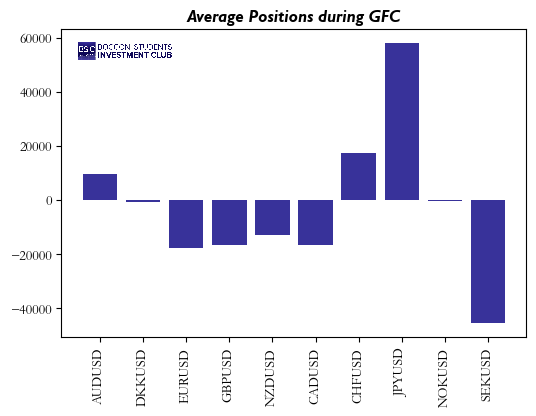

In [15]:
fig = plot_positions('2008-10','2009-04')

In [29]:
fig.savefig('../../output/bars_fede_2.svg', bbox_inches='tight', dpi=1200)

In [16]:
factors_gfc = run_factor_analysis("2008-10", "2009-04")

results_as_html = factors_gfc.summary().tables[1].as_html()
regr_results_gfc = pd.read_html(results_as_html, header=0, index_col=0)[0]
regr_results_gfc.to_excel('../../results/factors_gfc.xlsx')

                    Robust linear Model Regression Results                    
Dep. Variable:              total_pct   No. Observations:                    7
Model:                            RLM   Df Residuals:                        2
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 28 Nov 2023                                         
Time:                        23:39:29                                         
No. Iterations:                    50                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190   1.92e-06   9903.152      0.0

C:\Users\andre\AppData\Local\Temp\ipykernel_20532\56349422.py:4: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



## 2015

<Axes: >

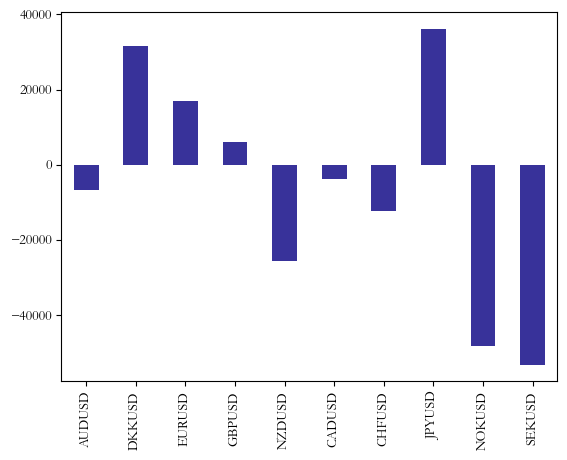

In [17]:
positions.loc['2014-10':'2015-07', :].mean(axis=0).plot(kind='bar')

In [18]:
run_factor_analysis('2014-06', '2015-01')

                    Robust linear Model Regression Results                    
Dep. Variable:              total_pct   No. Observations:                    8
Model:                            RLM   Df Residuals:                        3
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 28 Nov 2023                                         
Time:                        23:39:35                                         
No. Iterations:                    50                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.009      0.187      0.8

## Whole Period

In [22]:
factors_2000 = run_factor_analysis("2000", "2010")

results_as_html = factors_2000.summary().tables[1].as_html()
regr_results_2000 = pd.read_html(results_as_html, header=0, index_col=0)[0]
regr_results_2000

                    Robust linear Model Regression Results                    
Dep. Variable:              total_pct   No. Observations:                  132
Model:                            RLM   Df Residuals:                      127
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 28 Nov 2023                                         
Time:                        23:39:55                                         
No. Iterations:                    35                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.001      5.311      0.0

C:\Users\andre\AppData\Local\Temp\ipykernel_20532\897119887.py:4: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



coef  std err      z  P>|z|  [0.025  0.975]
const     0.0046    0.001  5.311  0.000   0.003   0.006
mkt       0.1848    0.111  1.659  0.097  -0.034   0.403
momentum -0.0363    0.037 -0.992  0.321  -0.108   0.035
value     0.1277    0.041  3.153  0.002   0.048   0.207
carry    -0.1024    0.031 -3.260  0.001  -0.164  -0.041

In [23]:
factors_2010 = run_factor_analysis("2010", "2020")

results_as_html = factors_2010.summary().tables[1].as_html()
regr_results_2010 = pd.read_html(results_as_html, header=0, index_col=0)[0]
regr_results_2010

                    Robust linear Model Regression Results                    
Dep. Variable:              total_pct   No. Observations:                  132
Model:                            RLM   Df Residuals:                      127
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 28 Nov 2023                                         
Time:                        23:39:57                                         
No. Iterations:                    20                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -1.280      0.2

C:\Users\andre\AppData\Local\Temp\ipykernel_20532\1146037753.py:4: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



coef  std err      z  P>|z|  [0.025  0.975]
const    -0.0010    0.001 -1.280  0.200  -0.003   0.001
mkt      -0.1177    0.127 -0.929  0.353  -0.366   0.131
momentum  0.0497    0.035  1.408  0.159  -0.019   0.119
value     0.0860    0.056  1.532  0.125  -0.024   0.196
carry    -0.0479    0.039 -1.220  0.222  -0.125   0.029

In [24]:
run_factor_analysis("2000", "2020")

                    Robust linear Model Regression Results                    
Dep. Variable:              total_pct   No. Observations:                  252
Model:                            RLM   Df Residuals:                      247
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 28 Nov 2023                                         
Time:                        23:39:59                                         
No. Iterations:                    29                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.254      0.0

In [21]:
regr_results_2000.to_excel('factors_2000s.xlsx')
regr_results_2010.to_excel('factors_2010s.xlsx')